In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [26]:
IMAGE_WIDTH, IMAGE_HEIGHT = 128, 128   # 입력 이미지 크기 (가로, 세로)
BATCH_SIZE = 32                        # 한 번에 처리할 이미지 수
EPOCHS = 20                            # 학습 반복 횟수
NUM_CLASSES = 7                        # 감정 클래스 개수 (시그모이드로 멀티라벨 출력)

In [27]:
DATA_DIR = r"c:\Users\admin\Desktop\project\2nd_ai_web_project\ai_model\Dog Emotion"
CSV_FILE = os.path.join(DATA_DIR, "labels.csv")

PRETRAINED_MODEL_PATH = r"c:\Users\admin\Desktop\project\2nd_ai_web_project\ai_model\dog_emotion_mobilenet_model_v1.h5"
FINE_TUNED_MODEL_PATH = r"c:\Users\admin\Desktop\project\2nd_ai_web_project\ai_model\dog_emotion_mobilenet_finetuned_v2.h5"

In [28]:
# ============================================
# [함수] create_mobilenet_model
# --------------------------------------------
# 목적:
#   - MobileNetV2 백본을 이용한 강아지 감정 분류 모델 생성
#   - 시그모이드(sgmoid) 활성화 사용 → 멀티라벨 감정(동시 복수 감정 가능) 학습에 적합
# --------------------------------------------
# 매개변수:
#   input_shape : 입력 이미지 크기 (예: (128, 128, 3) 또는 (224, 224, 3))
#   num_classes : 감정 클래스 개수 (예: 4 → [angry, happy, relaxed, sad])
# 반환값:
#   model : 학습 가능한 Keras Model 객체
# ============================================

def create_mobilenet_model(input_shape, num_classes):
    # 사전 학습된 MobileNetV2 불러오기 (imagenet 가중치)
    base_model = MobileNetV2(input_shape=input_shape,
                             include_top=False,    # FC층 제외 (feature extractor만 사용)
                             weights='imagenet')

    # 기본 모델(특징 추출기)은 고정 → 학습 중 가중치 업데이트 안 함
    base_model.trainable = False

    # 입력 정의
    inputs = tf.keras.Input(shape=input_shape)

    # 특징 추출
    x = base_model(inputs, training=False)   # dropout 등 BN 층의 학습 모드 방지
    x = GlobalAveragePooling2D()(x)          # 공간 차원 평균 → 벡터화

    # 분류 헤드 (완전연결층)
    x = Dense(512, activation='relu')(x)     # 감정 표현 학습
    x = Dropout(0.5)(x)                      # 과적합 방지

    # 출력층 — sigmoid로 감정별 확률 출력
    # (softmax가 아닌 sigmoid: 다중 감정 가능성을 동시에 예측)
    outputs = Dense(num_classes, activation='sigmoid')(x)

    # 전체 모델 구성
    model = Model(inputs, outputs)

    return model


In [29]:
# ============================================
# [함수] load_data
# --------------------------------------------
# labels.csv 예시 구조:
#   index, filename, label
#   85, DHtZ...e11071.jpg, angry
#   86, fu3AVXub...MSVyMz20.jpg, angry
# --------------------------------------------
# 매개변수:
#   csv_file      : labels.csv 파일 경로
#   data_dir      : Dog Emotion 폴더 경로
#   image_width   : 이미지 리사이즈 가로 크기
#   image_height  : 이미지 리사이즈 세로 크기
# 반환값:
#   df            : 파일 경로와 감정 라벨이 포함된 DataFrame
#   class_columns : 고유 감정 클래스 이름 목록 (예: ['angry','happy','relaxed','sad'])
# ============================================

def load_data(csv_file, data_dir, image_width, image_height):
    # CSV 파일 읽기
    df = pd.read_csv(csv_file, header=None, names=['index', 'filename', 'label'])
    
    # 고유 감정 라벨 추출
    class_columns = sorted(df['label'].unique().tolist())

    # 각 이미지의 전체 경로로 변경
    df['filename'] = df.apply(
        lambda row: os.path.join(data_dir, row['label'], row['filename']),
        axis=1
    )
    
    return df, class_columns

In [30]:
def prepare_data(csv_file, data_dir, image_width, image_height, batch_size):
    # CSV 로드: (index, filename, label) 구조를 load_data가 처리함
    # class_columns : ['angry','happy','relaxed','sad'] 같은 고유 라벨 목록(원-핫 순서 정의)
    df, class_columns = load_data(csv_file, data_dir, image_width, image_height)

    # 셔플 후 train/val 분리
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    validation_split_ratio = 0.2
    validation_samples = int(len(df) * validation_split_ratio)

    train_df = df.iloc[validation_samples:]
    validation_df = df.iloc[:validation_samples]

    num_classes = len(class_columns)

    # ✅ MobileNetV2 권장 전처리: preprocess_input 사용(픽셀을 [-1,1]로 스케일)
    #    → rescale=1./255 대신 사용
    train_datagen = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        rotation_range=30,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    validation_datagen = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    # ✅ 단일 라벨 컬럼('label')을 사용하여 원-핫 벡터 생성
    #    class_mode='categorical' → one-hot (num_classes 차원)
    #    classes=class_columns → 클래스 순서 고정(훈련/추론 시 일관성)
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='filename',
        y_col='label',
        classes=class_columns,
        target_size=(image_width, image_height),
        color_mode='rgb',
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        validate_filenames=True,
        seed=42
    )

    validation_generator = validation_datagen.flow_from_dataframe(
        dataframe=validation_df,
        x_col='filename',
        y_col='label',
        classes=class_columns,
        target_size=(image_width, image_height),
        color_mode='rgb',
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        validate_filenames=True
    )

    return train_generator, validation_generator, class_columns, num_classes


In [31]:
def build_and_compile_finetune_model(input_shape, num_classes, pretrained_model_path):
    """
    설명:
    - 사전학습 완료(.h5) 모델을 로드한 뒤, MobileNetV2 백본을 언프리즈하여 미세튜닝(fine-tuning)하는 함수
    - 손실은 sigmoid 다중라벨 가정에 맞춰 binary_crossentropy 유지
      (단일라벨+softmax로 바꾸면 categorical_crossentropy 권장)
    """
    model = tf.keras.models.load_model(pretrained_model_path)

    # --------------------------------------------
    # [중요] MobileNetV2 백본 언프리즈
    # Functional API로 구성된 경우, 서브모델로 안 잡힐 수 있어
    # 이름 기반으로 백본 레이어들을 견고하게 찾아서 trainable=True로 설정
    # --------------------------------------------
    # 1) 흔한 백본 이름 후보들 시도
    backbones = [
        "MobilenetV2",           # 대문자 시작
        "mobilenetv2_1.00_224",  # TF가 자동 부여하는 이름 패턴
        "mobilenetv2_1.00_160",
        "mobilenetv2_1.40_224",
        "mobilenetv2"            # 소문자 패턴
    ]
    backbone_found = False
    for name in backbones:
        try:
            base = model.get_layer(name)
            base.trainable = True
            backbone_found = True
            break
        except Exception:
            pass

    # 2) 위에서 못 찾았다면, 레이어 이름에 'mobilenetv2'가 들어간 것들을 직접 언프리즈
    if not backbone_found:
        for layer in model.layers:
            if "mobilenetv2" in layer.name.lower():
                layer.trainable = True
                backbone_found = True

    # 3) 그래도 못 찾으면(매우 드문 케이스) 안전하게 마지막 N개 레이어만 언프리즈
    if not backbone_found:
        N = 20  # 필요시 조정
        for layer in model.layers[-N:]:
            layer.trainable = True

    # --------------------------------------------
    # Optimizer는 미세튜닝이므로 작은 러닝레이트 권장
    # 손실함수는 시그모이드 멀티라벨 기준으로 BCE 유지
    # --------------------------------------------
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-5),  # fine-tuning은 낮은 LR
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.AUC(curve='ROC', name='AUC_ROC'),
            tf.keras.metrics.AUC(curve='PR',  name='AUC_PR')
        ]
    )

    model.summary()
    return model


In [32]:
def train_and_save_model(model, train_generator, validation_generator, epochs, batch_size):
    """
    설명:
    - 제너레이터로 학습/검증을 수행하고, 최적 가중치를 자동 저장
    - 콜백:
        * EarlyStopping: 과적합 방지, 베스트 가중치로 복원
        * ReduceLROnPlateau: 검증 성능이 정체되면 LR 자동 감소
        * ModelCheckpoint: 검증 손실 기준 '가장 좋은' 모델을 FINE_TUNED_MODEL_PATH에 저장
    - 마지막에 한 번 더 model.save()로 현재 모델 상태를 저장(백업 개념)
    """
    # 과적합 방지: 개선 없으면 조기 종료 + 베스트 가중치 복원
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    # 정체 구간에서 학습률 감소 → 더 미세한 수렴 유도
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-7,
        verbose=1
    )

    # 베스트 모델 자동 저장(검증 손실 최소 기준)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=FINE_TUNED_MODEL_PATH,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,   # 전체 모델(.h5) 저장
        verbose=1
    )

    history = model.fit(
        train_generator,
        steps_per_epoch=int(np.ceil(train_generator.samples / batch_size)),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=int(np.ceil(validation_generator.samples / batch_size)),
        callbacks=[early_stopping, reduce_lr, checkpoint],
        verbose=1
    )

    # 안전하게 한 번 더 저장(조기종료 직후 현재 상태 백업)
    model.save(FINE_TUNED_MODEL_PATH)
    print(f"Model trained and saved as {FINE_TUNED_MODEL_PATH}")

    return history


In [33]:
def evaluate_and_display_predictions(model_path, validation_generator, class_columns, threshold=0.5):
    """
    설명:
    - 저장된 모델(.h5)을 로드한 뒤, 검증 배치 1개로 예측 결과를 시각화
    - 단일 라벨(one-hot) 기준: argmax로 정답/예측 라벨 표시
    - 제너레이터가 MobileNetV2의 preprocess_input([-1,1])을 사용하므로,
      시각화 전에 (x+1)/2 로 역전처리하여 0..1 범위로 복원
    매개변수:
    - model_path        : 저장된 모델 경로
    - validation_generator : Keras DataFrameIterator (class_mode='categorical')
    - class_columns     : 라벨 이름 목록 (ex: ['angry','happy','relaxed','sad'])
    - threshold         : (멀티라벨 사용 시) 시그모이드 확률 임계값. 기본 0.5
    """
    # 모델 로드
    loaded_model = tf.keras.models.load_model(model_path)

    # 검증 배치 1개 가져오기
    validation_generator.reset()
    validation_images, validation_labels = next(validation_generator)

    # 예측
    predictions = loaded_model.predict(validation_images)

    # 이미지 역전처리: [-1,1] → [0,1]
    def deprocess(img):
        img = (img + 1.0) / 2.0
        return np.clip(img, 0.0, 1.0)

    # 시각화 (최대 9장)
    plt.figure(figsize=(10, 10))
    nshow = min(9, len(validation_images))
    for i in range(nshow):
        plt.subplot(3, 3, i + 1)
        plt.imshow(deprocess(validation_images[i]))

        # 단일 라벨(one-hot) → argmax로 정답 라벨
        true_idx = int(np.argmax(validation_labels[i]))
        true_label = class_columns[true_idx].replace('Unlabeled', 'No Emotion')

        # 예측 라벨: 단일 라벨 기준 top-1
        pred_idx = int(np.argmax(predictions[i]))
        predicted_label = class_columns[pred_idx].replace('Unlabeled', 'No Emotion')

        # (참고) 멀티라벨 사용 시:
        # present = [class_columns[j] for j, p in enumerate(predictions[i]) if p >= threshold]
        # predicted_label = ','.join(present) if present else 'No Emotion'

        plt.title(f"True: {true_label}\nPred: {predicted_label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


Found 3200 validated image filenames belonging to 5 classes.
Found 800 validated image filenames belonging to 5 classes.


C:\Users\admin\AppData\Roaming\Python\Python313\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


[INFO] Classes (order): ['angry', 'happy', 'label', 'relaxed', 'sad']  | num_classes: 5
[WARN] Pretrained model not found: c:\Users\admin\Desktop\project\2nd_ai_web_project\ai_model\dog_emotion_mobilenet_model_v1.h5
[INFO] Building a new MobileNetV2 model for training...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,916,421 (11.13 MB)

 Trainable params: 658,437 (2.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

C:\Users\admin\AppData\Roaming\Python\Python313\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - AUC_PR: 0.3817 - AUC_ROC: 0.7190 - accuracy: 0.3840 - loss: 0.4981
Epoch 1: val_loss improved from None to 0.33688, saving model to c:\Users\admin\Desktop\project\2nd_ai_web_project\ai_model\dog_emotion_mobilenet_finetuned_v2.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 80s 747ms/step - AUC_PR: 0.4629 - AUC_ROC: 0.7785 - accuracy: 0.4512 - loss: 0.4302 - val_AUC_PR: 0.6597 - val_AUC_ROC: 0.8735 - val_accuracy: 0.6037 - val_loss: 0.3369 - learning_rate: 0.0010
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - AUC_PR: 0.6116 - AUC_ROC: 0.8522 - accuracy: 0.5707 - loss: 0.3539
Epoch 2: val_loss improved from 0.33688 to 0.32249, saving model to c:\Users\admin\Desktop\project\2nd_ai_web_project\ai_model\dog_emotion_mobilenet_finetuned_v2.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 411ms/step - AUC_PR: 0.6176 - AUC_ROC: 0.8569 - accuracy: 0.5728 - loss: 0.3497 - val_AUC_PR: 0.6689 - val_AUC_ROC: 0.8844 - val_accuracy: 0.6263 - val_loss: 0.3225 - learning_rate: 0.0010
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - AUC_PR: 0.6577 - AUC_ROC: 0.8754 - accuracy: 0.6178 - loss: 0.3308
Epoch 3: val_loss improved from 0.32249 to 0.31922, saving model to c:\Users\admin\Desktop\project\2nd_ai_web_project\ai_model\dog_emotion_mobilenet_finetuned_v2.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 39s 394ms/step - AUC_PR: 0.6649 - AUC_ROC: 0.8789 - accuracy: 0.6216 - loss: 0.3270 - val_AUC_PR: 0.6781 - val_AUC_ROC: 0.8861 - val_accuracy: 0.6250 - val_loss: 0.3192 - learning_rate: 0.0010
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - AUC_PR: 0.6978 - AUC_ROC: 0.8936 - accuracy: 0.6410 - loss: 0.3090
Epoch 4: val_loss improved from 0.31922 to 0.31001, saving model to c:\Users\admin\Desktop\project\2nd_ai_web_project\ai_model\dog_emotion_mobilenet_finetuned_v2.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 39s 384ms/step - AUC_PR: 0.6941 - AUC_ROC: 0.8926 - accuracy: 0.6403 - loss: 0.3106 - val_AUC_PR: 0.6907 - val_AUC_ROC: 0.8944 - val_accuracy: 0.6162 - val_loss: 0.3100 - learning_rate: 0.0010
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - AUC_PR: 0.7120 - AUC_ROC: 0.8989 - accuracy: 0.6519 - loss: 0.3024
Epoch 5: val_loss improved from 0.31001 to 0.29970, saving model to c:\Users\admin\Desktop\project\2nd_ai_web_project\ai_model\dog_emotion_mobilenet_finetuned_v2.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 434ms/step - AUC_PR: 0.7045 - AUC_ROC: 0.8965 - accuracy: 0.6425 - loss: 0.3057 - val_AUC_PR: 0.7098 - val_AUC_ROC: 0.9031 - val_accuracy: 0.6650 - val_loss: 0.2997 - learning_rate: 0.0010
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - AUC_PR: 0.7143 - AUC_ROC: 0.9005 - accuracy: 0.6599 - loss: 0.3007
Epoch 6: val_loss improved from 0.29970 to 0.29827, saving model to c:\Users\admin\Desktop\project\2nd_ai_web_project\ai_model\dog_emotion_mobilenet_finetuned_v2.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 39s 392ms/step - AUC_PR: 0.7220 - AUC_ROC: 0.9032 - accuracy: 0.6594 - loss: 0.2974 - val_AUC_PR: 0.7184 - val_AUC_ROC: 0.9033 - val_accuracy: 0.6538 - val_loss: 0.2983 - learning_rate: 0.0010
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - AUC_PR: 0.7485 - AUC_ROC: 0.9131 - accuracy: 0.6867 - loss: 0.2835
Epoch 7: val_loss did not improve from 0.29827
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 398ms/step - AUC_PR: 0.7461 - AUC_ROC: 0.9131 - accuracy: 0.6834 - loss: 0.2834 - val_AUC_PR: 0.7012 - val_AUC_ROC: 0.8996 - val_accuracy: 0.6575 - val_loss: 0.3088 - learning_rate: 0.0010
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - AUC_PR: 0.7477 - AUC_ROC: 0.9162 - accuracy: 0.6891 - loss: 0.2803
Epoch 8: val_loss improved from 0.29827 to 0.28975, saving model to c:\Users\admin\Desktop\project\2nd_ai_web_project\ai_model\dog_emotion_mobilenet_finetuned_v2.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 38s 383ms/step - AUC_PR: 0.7498 - AUC_ROC: 0.9178 - accuracy: 0.6847 - loss: 0.2778 - val_AUC_PR: 0.7381 - val_AUC_ROC: 0.9097 - val_accuracy: 0.6725 - val_loss: 0.2897 - learning_rate: 0.0010
Epoch 9/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - AUC_PR: 0.7818 - AUC_ROC: 0.9281 - accuracy: 0.7127 - loss: 0.2620
Epoch 9: val_loss did not improve from 0.28975
100/100 ━━━━━━━━━━━━━━━━━━━━ 38s 378ms/step - AUC_PR: 0.7593 - AUC_ROC: 0.9192 - accuracy: 0.6916 - loss: 0.2752 - val_AUC_PR: 0.7321 - val_AUC_ROC: 0.9092 - val_accuracy: 0.6700 - val_loss: 0.2914 - learning_rate: 0.0010
Epoch 10/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - AUC_PR: 0.7618 - AUC_ROC: 0.9187 - accuracy: 0.6943 - loss: 0.2753
Epoch 10: val_loss improved from 0.28975 to 0.28836, saving model to c:\Users\admin\Desktop\project\2nd_ai_web_project\ai_model\dog_emotion_mobilenet_finetuned_v2.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 39s 389ms/step - AUC_PR: 0.7679 - AUC_ROC: 0.9226 - accuracy: 0.6975 - loss: 0.2699 - val_AUC_PR: 0.7427 - val_AUC_ROC: 0.9118 - val_accuracy: 0.6775 - val_loss: 0.2884 - learning_rate: 0.0010
Epoch 11/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - AUC_PR: 0.7751 - AUC_ROC: 0.9251 - accuracy: 0.6998 - loss: 0.2653
Epoch 11: val_loss did not improve from 0.28836
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 401ms/step - AUC_PR: 0.7892 - AUC_ROC: 0.9306 - accuracy: 0.7184 - loss: 0.2564 - val_AUC_PR: 0.7158 - val_AUC_ROC: 0.8989 - val_accuracy: 0.6538 - val_loss: 0.3143 - learning_rate: 0.0010
Epoch 12/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - AUC_PR: 0.7804 - AUC_ROC: 0.9289 - accuracy: 0.7098 - loss: 0.2609
Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 12: val_loss did not improve from 0.28836
100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 419ms/step - AUC_PR: 0.7869 - AUC_ROC: 0.9298 - accuracy: 0.7144 - loss: 0.2582 - val_AUC_PR: 0.7207 

Model trained and saved as c:\Users\admin\Desktop\project\2nd_ai_web_project\ai_model\dog_emotion_mobilenet_finetuned_v2.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


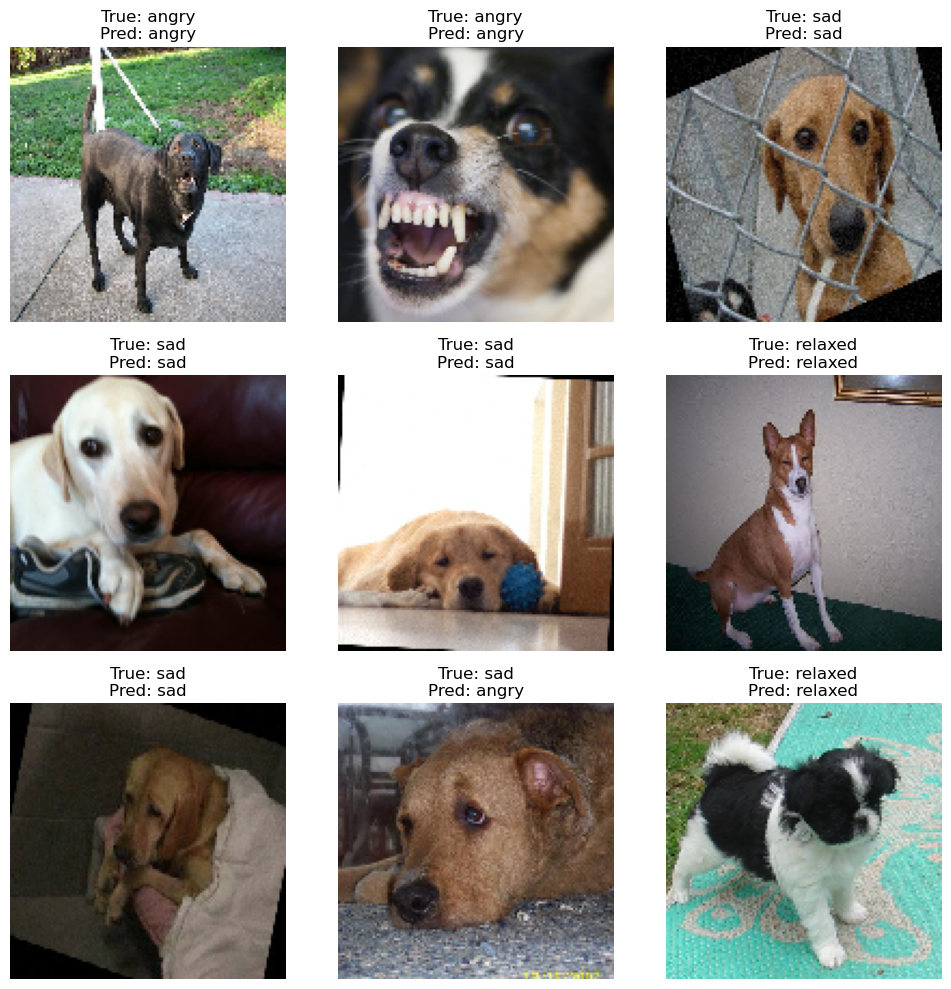

In [34]:
def train_model():
    # 1) 데이터 준비 (Dog Emotion: labels.csv의 index, filename, label 구조)
    train_generator, validation_generator, class_columns, num_classes = prepare_data(
        CSV_FILE, DATA_DIR, IMAGE_WIDTH, IMAGE_HEIGHT, BATCH_SIZE
    )

    # 디버깅/검증용: 클래스 순서 출력 (모델 출력과 정확히 매칭됨)
    print("[INFO] Classes (order):", class_columns, " | num_classes:", num_classes)

    # 2) 모델 준비
    #    - 사전학습 모델(.h5)이 있으면: 로드 후 MobileNetV2 백본 언프리즈 → 미세튜닝
    #    - 없으면: MobileNetV2 백본 + 시그모이드 출력으로 새 모델 생성(프리트레인 단계로 사용)
    if os.path.exists(PRETRAINED_MODEL_PATH):
        print(f"[INFO] Found pretrained model: {PRETRAINED_MODEL_PATH}")
        model = build_and_compile_finetune_model(
            (IMAGE_WIDTH, IMAGE_HEIGHT, 3), num_classes, PRETRAINED_MODEL_PATH
        )
    else:
        print(f"[WARN] Pretrained model not found: {PRETRAINED_MODEL_PATH}")
        print("[INFO] Building a new MobileNetV2 model for training...")
        model = create_mobilenet_model((IMAGE_WIDTH, IMAGE_HEIGHT, 3), num_classes)
        # 시그모이드 다중/단일 라벨 공통 → BCE 사용
        model.compile(
            optimizer=tf.keras.optimizers.Adam(1e-3),
            loss="binary_crossentropy",
            metrics=["accuracy",
                     tf.keras.metrics.AUC(curve="ROC", name="AUC_ROC"),
                     tf.keras.metrics.AUC(curve="PR",  name="AUC_PR")]
        )
        model.summary()

    # 3) 학습 + 베스트 모델 저장 (FINE_TUNED_MODEL_PATH)
    history = train_and_save_model(
        model, train_generator, validation_generator, EPOCHS, BATCH_SIZE
    )

    # 4) 간단 시각화 평가 (검증 배치 일부)
    evaluate_and_display_predictions(FINE_TUNED_MODEL_PATH, validation_generator, class_columns)


if __name__ == "__main__":
    train_model()
